# Анализ поведения пользователей мобильного приложения

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Ход исследования**

Исследование пройдёт в четыре этапа:

* Изучите и проверьте данные;
* Изучите воронку событий;
* Изучите результаты эксперимента;
* Выводы.

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore') 
from scipy import stats as st
from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
data = pd.read_csv('logs_exp.csv', sep='\t')

In [2]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# обзор данных

display(data['EventName'].unique())
display(data['ExpId'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

array([246, 248, 247], dtype=int64)

In [4]:
# проверка на явные дубликаты

display(data.duplicated().sum())
data.duplicated().sum() / len(data)

413

0.0016917493425526163

**Выводы**

Таблица содержит информацию о 244126-ти действиях пользователей или событий. Самих событий всего пять.


# Шаг 2. Подготовьте данные

**1. Замените названия столбцов на удобные для вас**

In [5]:
data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'}, inplace = True)
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [6]:
data['event_name'] = data['event_name'].str.lower()
data

,event_name,device_id_hash,event_timestamp,exp_id
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,mainscreenappear,4599628364049201812,1565212345,247
244122,mainscreenappear,5849806612437486590,1565212439,246
244123,mainscreenappear,5746969938801999050,1565212483,246
244124,mainscreenappear,5746969938801999050,1565212498,246


**2. Проверьте пропуски и типы данных. Откорректируйте, если нужно**

In [7]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event_name,device_id_hash,event_timestamp,exp_id
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248


In [8]:
data['device_id_hash'].isna().value_counts()

False    244126
Name: device_id_hash, dtype: int64

In [9]:
data['event_name'].isna().value_counts()

False    244126
Name: event_name, dtype: int64

In [10]:
data['exp_id'].isna().value_counts()

False    244126
Name: exp_id, dtype: int64

In [11]:
data['event_timestamp'].isna().value_counts()

False    244126
Name: event_timestamp, dtype: int64

Пропусков не обнаружилось

In [12]:
data.duplicated().sum()

413

In [13]:
data = data.drop_duplicates()
data.duplicated().sum()
data.reset_index(drop=True)

,event_name,device_id_hash,event_timestamp,exp_id
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,mainscreenappear,4599628364049201812,1565212345,247
243709,mainscreenappear,5849806612437486590,1565212439,246
243710,mainscreenappear,5746969938801999050,1565212483,246
243711,mainscreenappear,5746969938801999050,1565212498,246


In [14]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248


**3. Добавьте столбец даты и времени, а также отдельный столбец дат**

In [15]:
data['date'] = data.event_timestamp.dt.date
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [16]:
data_group = data.groupby('device_id_hash').agg({'exp_id' : 'nunique'})
data_group

,exp_id
device_id_hash,
6888746892508752,1
6909561520679493,1
6922444491712477,1
7435777799948366,1
7702139951469979,1
...,...
9217594193087726423,1
9219463515465815368,1
9220879493065341500,1


In [17]:
data_group.loc[data_group['exp_id'] > 1].count()

exp_id    0
dtype: int64

Все пользователи находятся в уникальных экпериментальных группах. Ни один из пользователей не попал в более чем одну экспериментальную группу.

# Шаг 3. Изучите и проверьте данные

**1. Сколько всего событий в логе?**

In [18]:
data['event_name'].value_counts()

mainscreenappear           119101
offersscreenappear          46808
cartscreenappear            42668
paymentscreensuccessful     34118
tutorial                     1018
Name: event_name, dtype: int64

**2. Сколько всего пользователей в логе?**

In [19]:
len(data['device_id_hash'].unique())

7551

Всего в логе участвовало 7551 уникальных пользователей.

**3. Сколько в среднем событий приходится на пользователя?**

In [20]:
events_per_user = data.pivot_table(index='device_id_hash',values='event_name',aggfunc='count')
round(events_per_user['event_name'].mean(), 1)

32.3

На одного пользователя в среднем приходится 32.3 событий.

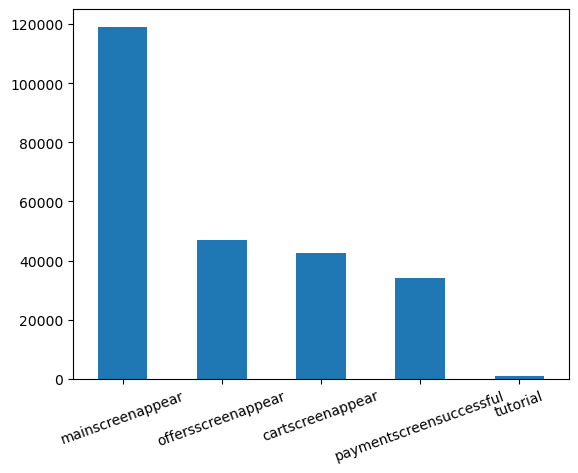

In [21]:
events = data['event_name'].value_counts()
events.plot.bar()
plt.xticks(rotation=20);

Из этой диаграммы можно заметить, что самый популярный ивент у пользователей — это открытие главного экрана, далее три события имеют практически одинаковую популярность у пользователей и событие показ туториала самое не популярное.

**4. Данными за какой период вы располагаете?**

In [22]:
print('Максимальная дата:', max(data['date']))

Максимальная дата: 2019-08-07


In [23]:
print('Минимальная дата:', min(data['date']))

Минимальная дата: 2019-07-25


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '2019-07-25'),
  Text(1, 0, '2019-07-26'),
  Text(2, 0, '2019-07-27'),
  Text(3, 0, '2019-07-28'),
  Text(4, 0, '2019-07-29'),
  Text(5, 0, '2019-07-30'),
  Text(6, 0, '2019-07-31'),
  Text(7, 0, '2019-08-01'),
  Text(8, 0, '2019-08-02'),
  Text(9, 0, '2019-08-03'),
  Text(10, 0, '2019-08-04'),
  Text(11, 0, '2019-08-05'),
  Text(12, 0, '2019-08-06'),
  Text(13, 0, '2019-08-07')])

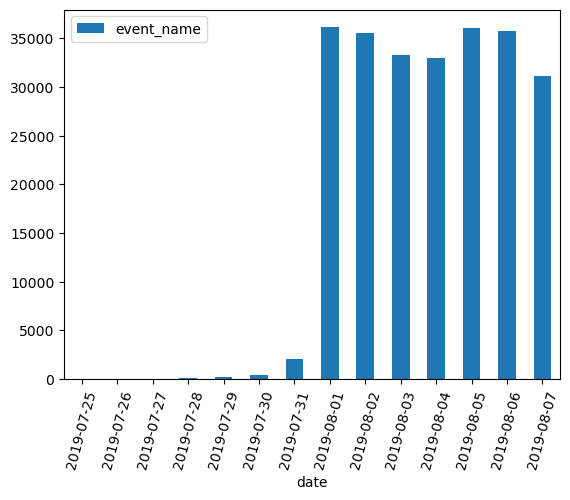

In [24]:
events_per_date = data[['date', 'event_name']]

events_per_date = events_per_date.groupby('date')['event_name'].count()
events_per_date = events_per_date.to_frame()
events_per_date.plot.bar()
plt.xticks(rotation=75)

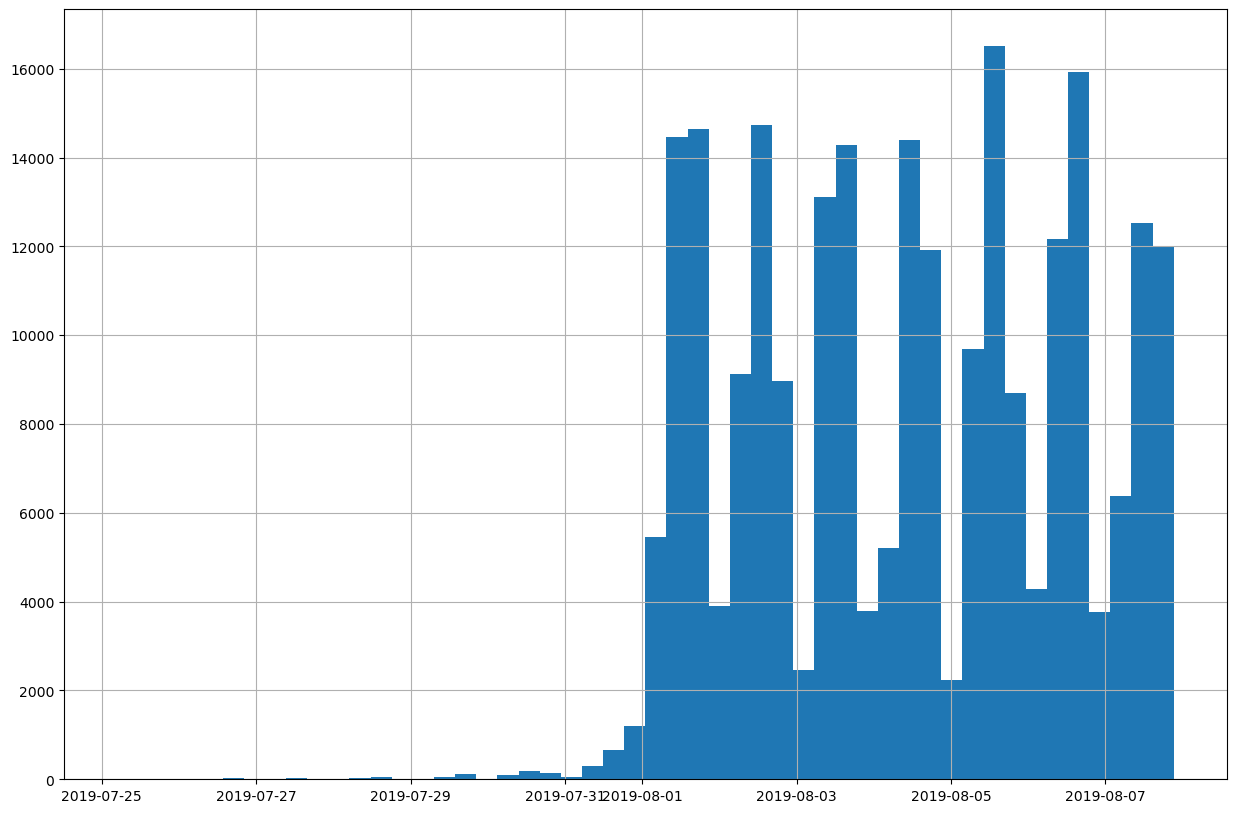

In [25]:
data['event_timestamp'].hist(bins=50, figsize=(15, 10));

Можно заметить, что до 2019-08-01 данных очень мало, и только начиная с 1-ого числа начинаются события. С этого момента мы можем оценивать результаты проведения эксперимента.

In [26]:
data['date'] = pd.to_datetime(data['date'])
data_new = data.query('date > "2019-07-31"')
data_new.groupby('date')['event_name'].count()

date
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

Данные за последние 7 дней.

**5.Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [27]:
print('Колличество потерянных значений:', data['event_name'].count() - data_new['event_name'].count())
print('Процент потерянных значений от изначального числа событий:', round((data['event_name'].count() - data_new['event_name'].count())/data['event_name'].count(), 4))

Колличество потерянных значений: 2826
Процент потерянных значений от изначального числа событий: 0.0116


Мы потеряли 1.16% событий.

In [28]:
# пользователи по событиям в новых данных:
data_pivot = data_new.pivot_table(index = 'event_name', 
                                  values = 'device_id_hash', 
                                  aggfunc = 'nunique').sort_values(by = 'device_id_hash', ascending = False)

In [29]:
# пользователи по событиям в старых данных:
data_old_pivot = data.pivot_table(index = 'event_name', 
                                  values = 'device_id_hash', 
                                  aggfunc = 'nunique').sort_values(by = 'device_id_hash', ascending = False)

In [30]:
differ = data_old_pivot - data_pivot
display(differ)

,device_id_hash
event_name,
mainscreenappear,20
offersscreenappear,20
cartscreenappear,15
paymentscreensuccessful,8
tutorial,7


In [31]:
print('Потеряно', differ['device_id_hash'].sum(), 'пользователей')

Потеряно 70 пользователей


In [32]:
print('Потерянных пользователей', round(differ['device_id_hash'].sum() / len(data['device_id_hash'].unique()) *100, 3) , '% от изначального числа пользователей')

Потерянных пользователей 0.927 % от изначального числа пользователей


**6.Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [33]:
data_new['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

В данных пользователи из всех трех экспериментальных групп.

# Шаг 4. Изучите воронку событий

**1. Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [34]:
data_new.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
2828,tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,mainscreenappear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,mainscreenappear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,offersscreenappear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,mainscreenappear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [35]:
data_new['event_name'].value_counts()

mainscreenappear           117328
offersscreenappear          46333
cartscreenappear            42303
paymentscreensuccessful     33918
tutorial                     1005
Name: event_name, dtype: int64

Событие 'mainscreenappear' самое частое. Туториал пользователи открывают реже всего

**2. Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей.Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [36]:
data_pivot = data_new.pivot_table(index = 'event_name', 
                                  values = 'device_id_hash', 
                                  aggfunc = 'nunique').sort_values(by = 'device_id_hash', ascending = False)
data_pivot

,device_id_hash
event_name,
mainscreenappear,7419
offersscreenappear,4593
cartscreenappear,3734
paymentscreensuccessful,3539
tutorial,840


Больше всего уникальных пользователей открывли главный экран и меньше всего уникальных пользователей заходили в туториал.

In [37]:
data_pivot['percentage'] = round(data_pivot['device_id_hash'] / data_new['device_id_hash'].nunique(), 3)*100
data_pivot

,device_id_hash,percentage
event_name,,
mainscreenappear,7419,98.5
offersscreenappear,4593,61.0
cartscreenappear,3734,49.6
paymentscreensuccessful,3539,47.0
tutorial,840,11.1


**3. Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

* Пользователь заходит и видит главный экран
* Пользователь заходит на экран покупок
* Пользователь выбирает товар на экране покупок и переходит на отдельную страницу с информацией по этому товару
* Пользователь оплачивает покупку

**4.По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

отбросим данные по tutorial

In [38]:
data_pivot.drop(['tutorial'], inplace=True)
data_pivot

,device_id_hash,percentage
event_name,,
mainscreenappear,7419,98.5
offersscreenappear,4593,61.0
cartscreenappear,3734,49.6
paymentscreensuccessful,3539,47.0


Посчитаем проценты пользователей на каждом шаге от предыдущего:

In [46]:
user_percentage = round((data_pivot['device_id_hash'].pct_change().fillna(0)+1), 2)
data_pivot['conversion'] = round((data_pivot['device_id_hash'].pct_change().fillna(0)+1)*100, 2)
data_pivot

,device_id_hash,percentage,conversion
event_name,,,
mainscreenappear,7419,98.5,100.00
offersscreenappear,4593,61.0,61.91
cartscreenappear,3734,49.6,81.30
paymentscreensuccessful,3539,47.0,94.78


Построим воронку, чтобы  увидеть, сколько пользователей мы теряем на разных этапах.

In [ ]:
data = dict(number=data_pivot['device_id_hash'],
            stage=["mainscreenappear", "offersscreenappear", "cartscreenappear", "paymentscreensuccessful"])
fig = px.funnel(data, x='number', y='stage')
fig.show()

**5. На каком шаге теряете больше всего пользователей?**

При переходе с главного экрана на экран покупок мы теряем больше всего пользователей. Но если пользователей перешел на экран покупок, то существует большая вероятность что он что-либо купит.

**6. Какая доля пользователей доходит от первого события до оплаты?**

Перемножим вероятноти прохождения всех шагов. Вероятность, что пользователь пройдет с первого шага на второй шаг 61.91% и тп.

In [48]:
print('Доля пользователй от первого события до оплаты:', round(user_percentage[0]*user_percentage[1]*user_percentage[2]*user_percentage[3]*100, 1), '%')

Доля пользователй от первого события до оплаты: 47.7 %


# Шаг 5. Изучите результаты эксперимента

**1. Сколько пользователей в каждой экспериментальной группе?**

In [49]:
data_group_pivot = data_new.pivot_table(index = 'exp_id', values = 'device_id_hash', aggfunc = 'nunique')
data_group_pivot

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


**2./3. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
 Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

In [50]:
#количество пользователей в разных группах по событиям и группам экперимена:
users_per = data_new.pivot_table(index = 'exp_id', columns = 'event_name', values = 'device_id_hash', aggfunc = 'nunique').reset_index()
del users_per['tutorial']
users_per

event_name,exp_id,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful
0,246,1266,2450,1542,1200
1,247,1238,2476,1520,1158
2,248,1230,2493,1531,1181


In [51]:
#Общее колличество пользователей в группах эксперимента
users_all_per = data_new.groupby('exp_id')['device_id_hash'].nunique()
users_per['users_all_per'] = users_per['exp_id'].apply(lambda x: users_all_per.loc[x])
users_per = users_per.set_index('exp_id')
users_per

event_name,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful,users_all_per
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


**Функция гипотезы по Z-критерию:**

In [ ]:
def z_test(success, trials, alpha):
    
    p1 = success[0] / trials[0]
    p2 = success[1] / trials[1]
    
    p_combined = (success[0]+success[1]) / (trials[1]+trials[0])
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1-p_combined)*(1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [ ]:
def test_automatic (A, B, alpha):
    
    alpha_test = alpha
    
    count_users = ([users_per['users_all_per'][A], 
                    users_per['users_all_per'][B]])
    
    count_MainScreenAppear = ([users_per['mainscreenappear'][A], 
                               users_per['mainscreenappear'][B]])
    
    count_OffersScreenAppear = ([users_per['offersscreenappear'][A], 
                                 users_per['offersscreenappear'][B]])
    
    count_CartScreenAppear = ([users_per['cartscreenappear'][A], 
                               users_per['cartscreenappear'][B]])
    
    count_PaymentScreenSuccessful = ([users_per['paymentscreensuccessful'][A], 
                                      users_per['paymentscreensuccessful'][B]])
    
    print('Результаты теста по count_users и count_MainScreenAppear для групп')
    z_test(count_MainScreenAppear, count_users, alpha_test)
    print('')
    
    print('Результаты теста по count_OffersScreenAppear и count_users для групп')
    z_test(count_OffersScreenAppear, count_users, alpha_test)
    print('')
    
    print('Результаты теста по count_users и count_CartScreenAppear для групп')
    z_test(count_CartScreenAppear, count_users, alpha_test)
    print('')
    
    print('Результаты теста по count_PaymentScreenSuccessful и count_users для групп')
    z_test(count_PaymentScreenSuccessful, count_users, alpha_test)

H0: доли уникальных посетителей в экпериментальных группах 246 и 247, побывавших на этапе воронки, одинаковы.

H1: между долями уникальных посетителей в экпериментальных группах 246 и 247, побывавших на этапе воронки, есть значимая разница.

alpha = 0.05

In [ ]:
test_automatic(246, 247, 0.05)

Статистической разницы между группами 246 и 247 нет.

H0: доли уникальных посетителей в экпериментальных группах 246 и 248, побывавших на этапе воронки, одинаковы.

H1: между долями уникальных посетителей в экпериментальных группах 246 и 248, побывавших на этапе воронки, есть значимая разница.

alpha =  0.05

In [ ]:
test_automatic(246, 248, 0.05)

Статистической разницы между группами 246 и 248 нет.

H0: доли уникальных посетителей в экпериментальных группах 247 и 248, побывавших на этапе воронки, одинаковы.

H1: между долями уникальных посетителей в экпериментальных группах 247 и 248, побывавших на этапе воронки, есть значимая разница.

alpha = 0.05

In [ ]:
test_automatic(247, 248, 0.05)

Статистической разницы между группами 247 и 248 нет.

**Объединяем группы 246 и 247**

In [ ]:
users_per

In [ ]:
users_per.loc['246+247'] = [users_per['cartscreenappear'][246] + users_per['cartscreenappear'][247] ,
                              users_per['mainscreenappear'][246] + users_per['mainscreenappear'][247],
                              users_per['offersscreenappear'][246] + users_per['offersscreenappear'][247],
                              users_per['paymentscreensuccessful'][246] + users_per['paymentscreensuccessful'][247],
                              users_per['users_all_per'][246] + users_per['users_all_per'][247]]
users_per

H0: доли уникальных посетителей в экпериментальных группах 248 и 249, побывавших на этапе воронки, одинаковы.

H1: между долями уникальных посетителей в экпериментальных группах 248 и 249, побывавших на этапе воронки, есть значимая разница.

alpha = 0.05

In [ ]:
test_automatic('246+247', 248, 0.05)

Статистической разницы между группами 249 и 248 нет.

# Вывод

Было выявлено, что:

* Главную страницу увидели 7419 пользователей (100% от общего числа пользователей);
* Страницу товара просмотрели 4593 пользователей (61,9% от общего числа);
* Карточку просмотрели 3734 пользователя (50.3% от общего числа);
* Завершили оплату 3539 пользователей (47,7% от общего числа).

Tutorial было исключено изза отсутствия влияния на остальные шаги.

В эксперименте были учтено поведение пользователей, разделенных на три группы:

* 246-ая - 2484 пользователя;
* 247-ая - 2513 пользователя;
* 248-ая - 2537 пользователя.

Согласно предложенному процессу, нам нужно было сопоставить доли пользователей по каждому событию между:

* контрольными группами 246 и 247;
* каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248);
* объединенной контрольной группой и экспериментальной (246+247 и 248).

После проведённых по каждому из событий тесту, не обнаружили статистически значимой разницы между группами. Изменение шрифтов во всём приложении на поведение пользователей не повлияло.